In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.2.1
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


# 为训练做准备

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms


# 定义数据集的变换
transform = transforms.Compose([
    transforms.ToTensor(), # 转换为tensor，进行归一化
    # transforms.Normalize(mean, std) # 标准化，mean和std是数据集的均值和方差
])
# fashion_mnist图像分类数据集，衣服分类，60000张训练图片，10000张测试图片
train_ds = datasets.FashionMNIST(
    root="../data1",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.FashionMNIST(
    root="../data1",
    train=False,
    download=True,
    transform=transform
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

In [4]:
img, label = train_ds[0]
img.shape  #img这时是一个tensor，shape=(1, 28, 28)

torch.Size([1, 28, 28])

In [5]:
#计算均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:  # 遍历每张图片,img.shape=[1,28,28]
        mean += img.mean(dim=(1, 2))  # 计算每张图片的均值，dim=(1, 2)表示计算每张图片的每一个像素的均值,行列共同求均值
        std += img.std(dim=(1, 2))
    # 平均均值和平均标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std


print(cal_mean_std(train_ds))


(tensor([0.2860]), tensor([0.3205]))


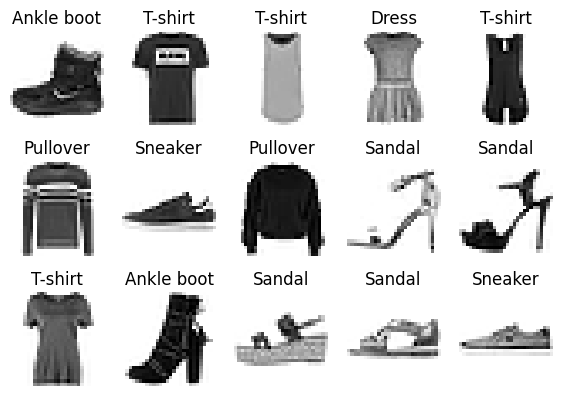

In [6]:
def show_imgs(n_rows, n_cols, train_ds, class_names):
    assert n_rows * n_cols < len(train_ds)  #确保打印的图片小于总样本数
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))  #宽1.4高1.6，宽，高
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col  # 计算索引，从0开始
            plt.subplot(n_rows, n_cols, index+1)#因为从1开始
            img_arr, label = train_ds[index]
            img_arr = np.transpose(img_arr, (1, 2, 0))  # 通道换到最后一维
            plt.imshow(img_arr, cmap="binary",
                       interpolation = 'nearest')#interpolation='nearest'是临近插值
            plt.axis('off')#去除坐标系
            plt.title(class_names[label]) # 显示类别名称
    plt.show()
    
    

#已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot'] #0-9分别代表的类别
#只是打印了前15个样本
show_imgs(3, 5, train_ds, class_names)


In [7]:
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True) #batch_size分批，shuffle洗牌
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [8]:
for datas, labels in train_loader:
    print(datas.shape)
    print(labels.shape)
    break
#查看val_loader
for datas, labels in val_loader:
    print(datas.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])
torch.Size([32, 1, 28, 28])
torch.Size([32])


# 定义模型

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # 继承父类的初始化方法，子类有父类的属性
        self.flatten = nn.Flatten()  # 展平层
        self.linear_relu_stack = nn.Sequential(  # 每一层的输出会作为下一层的输入
            nn.Linear(784, 300),  # in_features=784, out_features=300, 784是输入特征数，300是输出特征数
            nn.ReLU(), # 激活函数
            nn.Linear(300, 100),#隐藏层神经元数100
            nn.ReLU(), # 激活函数
            nn.Linear(100, 10),#输出层神经元数10 
        )

    def forward(self, x): # 前向计算，前向传播
        # x.shape [batch size, 1, 28, 28],1是通道数
        x = self.flatten(x)  
        # print(f'x.shape--{x.shape}')
        # 展平后 x.shape [batch size, 784]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits #没有经过softmax,称为logits
    
model = NeuralNetwork()

In [10]:
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [11]:
#为了查看模型运算的tensor尺寸
x = torch.randn(32, 1, 28, 28)
print(x.shape)
logits = model(x)
print(logits.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [12]:
for name, param in model.named_parameters(): # 打印模型参数
      print(name, param.shape)

linear_relu_stack.0.weight torch.Size([300, 784])
linear_relu_stack.0.bias torch.Size([300])
linear_relu_stack.2.weight torch.Size([100, 300])
linear_relu_stack.2.bias torch.Size([100])
linear_relu_stack.4.weight torch.Size([10, 100])
linear_relu_stack.4.bias torch.Size([10])


In [13]:
# 看看模型参数
list(model.parameters())  # 这种方法拿到模型的所有可学习参数,requires_grad=True

[Parameter containing:
 tensor([[-2.2431e-02, -1.5741e-02,  2.2493e-02,  ..., -2.4588e-02,
           1.6619e-02, -2.8542e-02],
         [ 2.6040e-02,  3.2936e-02,  2.7657e-02,  ...,  3.4042e-02,
          -2.2728e-02, -3.2147e-02],
         [ 3.2969e-02,  3.9970e-03,  1.5413e-02,  ...,  1.3678e-02,
           3.3595e-02,  2.4341e-03],
         ...,
         [ 3.5233e-02, -1.7625e-02, -5.4833e-05,  ..., -2.1966e-02,
           8.6365e-04, -3.5479e-03],
         [-8.8941e-03, -1.7646e-02, -1.0600e-02,  ...,  3.5271e-02,
          -1.8503e-02, -3.4779e-02],
         [-3.2616e-02,  8.2595e-03,  1.6630e-02,  ...,  1.0125e-02,
           2.5070e-02,  7.6835e-03]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0134,  0.0216, -0.0200, -0.0294,  0.0032, -0.0035, -0.0009,  0.0305,
          0.0258,  0.0283, -0.0011, -0.0283,  0.0178, -0.0308,  0.0221,  0.0250,
          0.0123, -0.0118, -0.0173, -0.0073, -0.0094,  0.0236,  0.0093,  0.0093,
          0.0157, -0.0013,  0.0147, -0.0310, 

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [14]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss() #内部先做softmax，然后计算交叉熵
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package,随机梯度下降
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,#控制参数更新的步长
                            momentum=0.9)#用于加速梯度下降并减少震荡

In [15]:
from sklearn.metrics import accuracy_score

@torch.no_grad() # 装饰器，禁止反向传播，节省内存(用于禁用梯度计算)
def evaluating(model, dataloader, loss_fct):
    loss_list = [] # 记录损失
    pred_list = [] # 记录预测
    label_list = [] # 记录标签
    for datas, labels in dataloader:#10000/32=312
        datas = datas.to(device) # 转到GPU
        labels = labels.to(device) # 转到GPU
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失,loss尺寸是一个数值
        loss_list.append(loss.item()) # 记录损失,item是把tensor转换为数值
        
        preds = logits.argmax(axis=-1)    # 验证集预测,argmax返回最大值索引
        # print(preds)
        pred_list.extend(preds.cpu().numpy().tolist())#将PyTorch张量转换为NumPy数组。只有当张量在CPU上时，这个转换才是合法的
        # print(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list) # 计算准确率
    return np.mean(loss_list), acc


In [17]:
def training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=500):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    #tqdm是一个进度条库
    with tqdm(total=epoch * len(train_loader)) as pbar: # 进度条 1875*20,60000/32=1875
        for epoch_id in range(epoch): # 训练epoch次
            # training
            for datas, labels in train_loader: #执行次数是60000/32=1875
                datas = datas.to(device) #datas尺寸是[batch_size,1,28,28]
                labels = labels.to(device) #labels尺寸是[batch_size]
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传，loss.backward()会计算梯度，loss对模型参数求导
                loss.backward()
                # 调整优化器，包括学习率的变动等,优化器的学习率会随着训练的进行而减小，更新w,b
                optimizer.step() #梯度是计算并存储在模型参数的 .grad 属性中，优化器使用这些存储的梯度来更新模型参数

                preds = logits.argmax(axis=-1) # 训练集预测
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())   # 计算准确率，numpy可以
                loss = loss.cpu().item() # 损失转到CPU，item()取值,一个数值
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                }) # 记录训练集信息，每一步的损失，准确率，步数
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval() # 进入评估模式
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train() # 进入训练模式

                # udate step
                global_step += 1 # 全局步数加1
                pbar.update(1) # 更新进度条
                pbar.set_postfix({"epoch": epoch_id}) # 设置进度条显示信息
        
    return record_dict
        

epoch = 40
model = model.to(device)
record = training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=1000)

  0%|          | 0/75000 [00:00<?, ?it/s]

In [18]:
record["train"][-5:]

[{'loss': 0.07803583145141602, 'acc': 1.0, 'step': 74995},
 {'loss': 0.1204468235373497, 'acc': 0.90625, 'step': 74996},
 {'loss': 0.18892985582351685, 'acc': 0.90625, 'step': 74997},
 {'loss': 0.19253671169281006, 'acc': 0.96875, 'step': 74998},
 {'loss': 0.20169687271118164, 'acc': 0.875, 'step': 74999}]

In [19]:
record["val"][-5:]

[{'loss': np.float64(0.3256912865518286), 'acc': 0.8913, 'step': 70000},
 {'loss': np.float64(0.32265188409307133), 'acc': 0.8924, 'step': 71000},
 {'loss': np.float64(0.33434143385138754), 'acc': 0.8907, 'step': 72000},
 {'loss': np.float64(0.33321493453444384), 'acc': 0.8867, 'step': 73000},
 {'loss': np.float64(0.369261731890539), 'acc': 0.8772, 'step': 74000}]

step
0        0.87500
1000     0.96875
2000     0.90625
3000     0.96875
4000     0.90625
          ...   
70000    0.93750
71000    0.96875
72000    0.90625
73000    1.00000
74000    0.96875
Name: acc, Length: 75, dtype: float64
step
0        0.8731
1000     0.8689
2000     0.8775
3000     0.8751
4000     0.8739
          ...  
70000    0.8913
71000    0.8924
72000    0.8907
73000    0.8867
74000    0.8772
Name: acc, Length: 75, dtype: float64


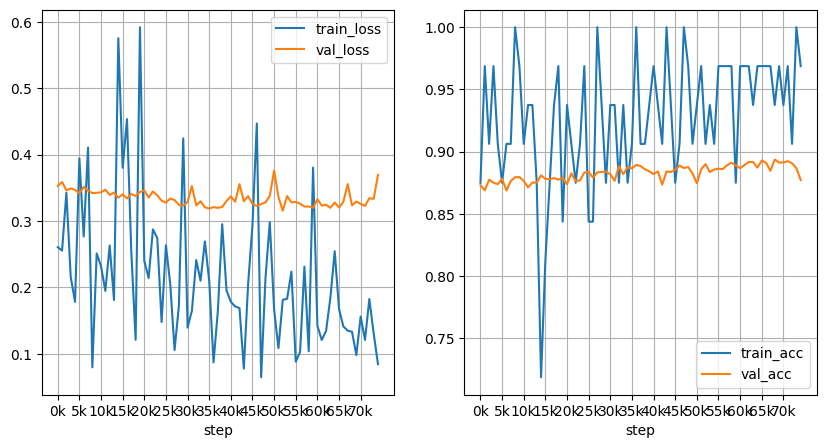

In [20]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=1000):
    # build DataFrame
    # 设置 "step" 列为索引,每隔 sample_step 步取一个数据点
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    # 验证数据通常较少，因此不需要采样
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    last_step = train_df.index[-1] # 最后一步的步数
    # print(train_df.columns)
    print(train_df['acc'])
    print(val_df['acc'])
    # plot
    fig_num = len(train_df.columns) # 画几张图,分别是损失和准确率
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        # print(train_df[item].values)
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid() # 显示网格
        axs[idx].legend() # 显示图例
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000)) # 设置x轴刻度
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, last_step, 5000))) # 设置x轴标签
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record)  #横坐标是 steps

# 评估

In [21]:
# dataload for evaluating

model.eval() # 进入评估模式
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3414
accuracy: 0.8868
